# **Resturant Reviews Sentiment Detection**
> 🤔 In this project we are going to build a model that will be able to predict the Sentiment of a review given by a customer in a resturant. The model will be called `RRSDNet`

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading Data & Exploring Data

In [3]:
df = pd.read_csv('/content/sentiment_formated.csv', encoding='latin-1')
df.head()

,Reviews,Liked
0,Wow... Loved this place.,1
1,Stopped by during the late May bank holiday of...,1
2,The selection on the menu was great and so wer...,1
3,The fries were great too.,1
4,A great touch.,1


In [4]:
df.shape

(1000, 2)

In [5]:
# checking for nan values
df.isnull().sum()

Reviews    0
Liked      0
dtype: int64

In [6]:
# checking for duplicated_values
df.duplicated().sum()

6

In [7]:
df = df.drop_duplicates()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 994 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Reviews  994 non-null    object
 1   Liked    994 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 23.3+ KB


<Axes: xlabel='Liked', ylabel='count'>

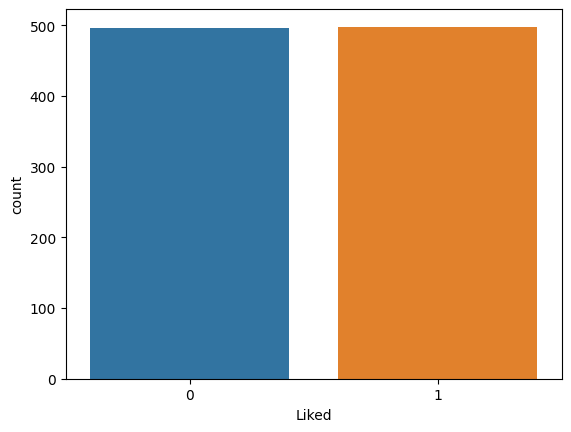

In [9]:
import seaborn as sns
sns.countplot(x='Liked', data=df)

In [10]:
df = df.sample(frac=1)
df.head()

,Reviews,Liked
239,Service is quick and friendly.,1
91,Restaurant is always full but never a wait.,1
962,She was quite disappointed although some blame...,0
944,The cashew cream sauce was bland and the veget...,0
269,Delicious and I will absolutely be back!,1


In [11]:
df.shape

(994, 2)

In [12]:
X = df.drop('Liked', axis=1).to_numpy()[:, 0]
y = df['Liked'].to_numpy()

In [13]:
X.shape, y.shape

((994,), (994,))

In [14]:
X[:5]

array(['Service is quick and friendly.',
       'Restaurant is always full but never a wait.',
       'She was quite disappointed although some blame needs to be placed at her door.',
       'The cashew cream sauce was bland and the vegetables were undercooked.',
       'Delicious and I will absolutely be back!'], dtype=object)

In [15]:
text_lens = [len(text.split()) for text in X]
text_lens[:5]

[5, 8, 14, 11, 7]

(array([159., 194., 197., 150.,  95.,  87.,  53.,  37.,  15.,   7.]),
 array([ 1. ,  4.1,  7.2, 10.3, 13.4, 16.5, 19.6, 22.7, 25.8, 28.9, 32. ]),
 <BarContainer object of 10 artists>)

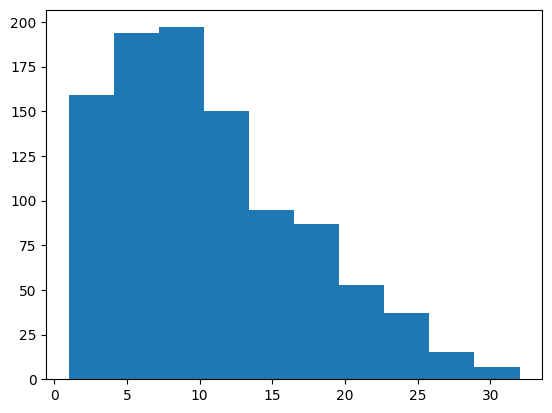

In [16]:
plt.hist(text_lens)

In [17]:
int(sum(text_lens)/len(text_lens)) # The average number of tokens

10

In [18]:
np.percentile(text_lens, 95)

23.0

## Setting up TextVectorization Layers

In [19]:
from tensorflow.keras.layers import TextVectorization

max_vocab = 20000
seq_len = 25

text_vectorizer = TextVectorization(
    max_tokens=max_vocab,
    output_sequence_length=seq_len,
    output_mode='int'
)

text_vectorizer.adapt(X)

In [20]:
# visualize random setence without and with Text-Vectorization
import random
random_tweet = random.choice(X)
print(f'Original Tweet : \n {random_tweet}')
text_vectorized_tweet = text_vectorizer([random_tweet])
print(f'Vectorized Tweet : \n {text_vectorized_tweet}\n Shape = {text_vectorized_tweet.shape}')

Original Tweet : 
 This is the place where I first had pho and it was amazing!!
Vectorized Tweet : 
 [[  9   8   2  16 259   4 104  23 272   3  10   5  71   0   0   0   0   0
    0   0   0   0   0   0   0]]
 Shape = (1, 25)


In [21]:
review_vocab = text_vectorizer.get_vocabulary()
print(f'Words in vocabulary : {len(review_vocab)}')
print(f'Top 5 words : {review_vocab[:5]}')
print(f'Bottom 5 words : {review_vocab[-5:]}')

Words in vocabulary : 2076
Top 5 words : ['', '[UNK]', 'the', 'and', 'i']
Bottom 5 words : ['1979', '17', '15lb', '15', '1199']


In [22]:
vectorized_X = text_vectorizer(X)
vectorized_X

<tf.Tensor: shape=(994, 25), dtype=int64, numpy=
array([[  18,    8,  312, ...,    0,    0,    0],
       [  61,    8,  119, ...,    0,    0,    0],
       [ 180,    5,  215, ...,    0,    0,    0],
       ...,
       [   2,   12,    8, ...,    0,    0,    0],
       [  24,   16,    7, ...,    0,    0,    0],
       [  35,   27, 1641, ...,    0,    0,    0]])>

## Build faster **data input pipelines** using `tf.data`

In [23]:
data = tf.data.Dataset.from_tensor_slices((vectorized_X, y))
data = data.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [24]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 25), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [25]:
batch_X, batch_y = data.as_numpy_iterator().next()
batch_X.shape, batch_y.shape

((32, 25), (32,))

In [26]:
batch_X

array([[  18,    8,  312,    3,   58,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [  61,    8,  119,  328,   31,   65,    6,  122,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 180,    5,  215,   91,  573,   78, 1973,  379,    7,   26, 1289,
          37,  282,  541,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   2, 1912,  409,  165,    5,  160,    3,    2,  355,   27,  598,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [  69,    3,    4,   43,  231,   26,   33,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [  17,   18,   20,  196,    3,  733,    7,  848,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  

In [27]:
batch_y

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0])

### Partioning the Data into Training and Testing Data

In [28]:
len(data)

32

In [29]:
train_data = data.take(int(len(data)*0.9))
test_data = data.skip(int(len(data)*0.9)).take(int(len(data)*0.1))

In [30]:
len(train_data), len(test_data)

(28, 3)

In [31]:
train_data

<_TakeDataset element_spec=(TensorSpec(shape=(None, 25), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Model Building

In [32]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import Bidirectional, LSTM
from keras.layers import Dense, BatchNormalization, Dropout

In [33]:
import os
# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name):
  return tf.keras.callbacks.ModelCheckpoint(filepath=f"./model_experiments/{model_name}/",
                                            monitor='val_accuracy', # create filepath to model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Bidirectional LSTM model

In [34]:
lstm_model = Sequential()
lstm_model.add(tf.keras.layers.Embedding(
    input_dim=len(review_vocab),
    output_dim=128,
    input_length=seq_len
))
lstm_model.add(Bidirectional(LSTM(32, activation='tanh', return_sequences=True)))
lstm_model.add(Bidirectional(LSTM(16, activation='tanh')))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

In [35]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 128)           265728    
                                                                 
 bidirectional (Bidirection  (None, 25, 64)            41216     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3

In [36]:
lstm_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [37]:
history_lstm = lstm_model.fit(
    train_data,
    epochs=20,
    validation_data=test_data,
    callbacks=[create_model_checkpoint('Bi_lstm_model')]
)

Epoch 1/20
28/28 [==============================] - 38s 924ms/step - loss: 0.6934 - accuracy: 0.4821 - val_loss: 0.6903 - val_accuracy: 0.5000
Epoch 2/20
28/28 [==============================] - 20s 751ms/step - loss: 0.6738 - accuracy: 0.5703 - val_loss: 0.6379 - val_accuracy: 0.7396
Epoch 3/20
28/28 [==============================] - 20s 733ms/step - loss: 0.4654 - accuracy: 0.8404 - val_loss: 0.4503 - val_accuracy: 0.8125
Epoch 4/20
28/28 [==============================] - 20s 741ms/step - loss: 0.2189 - accuracy: 0.9375 - val_loss: 0.4366 - val_accuracy: 0.8438
Epoch 5/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0879 - accuracy: 0.9866 - val_loss: 0.6155 - val_accuracy: 0.8438
Epoch 6/20
28/28 [==============================] - 0s 11ms/step - loss: 0.0403 - accuracy: 0.9955 - val_loss: 0.7484 - val_accuracy: 0.8438
Epoch 7/20
28/28 [==============================] - 20s 739ms/step - loss: 0.0379 - accuracy: 0.9933 - val_loss: 0.7293 - val_accuracy: 0.8542
Epo

## Bidirectional GRU layer

In [38]:
gru_model = Sequential()
gru_model.add(tf.keras.layers.Embedding(
    input_dim=len(review_vocab),
    output_dim=128,
    input_length=seq_len
))
gru_model.add(Bidirectional(tf.keras.layers.GRU(32, activation='tanh', return_sequences=True)))
gru_model.add(Bidirectional(tf.keras.layers.GRU(16, activation='tanh')))
gru_model.add(Dense(32, activation='relu'))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation='sigmoid'))

In [40]:
gru_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [41]:
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 128)           265728    
                                                                 
 bidirectional_2 (Bidirecti  (None, 25, 64)            31104     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 32)                7872      
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [42]:
history_gru = gru_model.fit(
    train_data,
    epochs=20,
    validation_data=test_data,
    callbacks=[create_model_checkpoint('Gru_model')]
)

Epoch 1/20
28/28 [==============================] - 32s 813ms/step - loss: 0.6880 - accuracy: 0.5312 - val_loss: 0.6729 - val_accuracy: 0.6667
Epoch 2/20
28/28 [==============================] - 17s 637ms/step - loss: 0.5865 - accuracy: 0.7455 - val_loss: 0.5120 - val_accuracy: 0.7604
Epoch 3/20
28/28 [==============================] - 18s 662ms/step - loss: 0.2666 - accuracy: 0.9096 - val_loss: 0.5146 - val_accuracy: 0.8229
Epoch 4/20
28/28 [==============================] - 0s 11ms/step - loss: 0.0845 - accuracy: 0.9777 - val_loss: 0.6669 - val_accuracy: 0.8229
Epoch 5/20
28/28 [==============================] - 0s 11ms/step - loss: 0.0708 - accuracy: 0.9777 - val_loss: 0.7370 - val_accuracy: 0.8021
Epoch 6/20
28/28 [==============================] - 0s 11ms/step - loss: 0.0229 - accuracy: 0.9955 - val_loss: 0.8102 - val_accuracy: 0.8125
Epoch 7/20
28/28 [==============================] - 0s 11ms/step - loss: 0.0153 - accuracy: 0.9967 - val_loss: 0.9394 - val_accuracy: 0.8021
Epoch 8

## Evaluating all Models

In [43]:
lstm_model.evaluate(test_data)

3/3 [==============================] - 0s 7ms/step - loss: 1.1745 - accuracy: 0.8125


[1.1744738817214966, 0.8125]

In [44]:
lstm_model = tf.keras.models.load_model('/content/model_experiments/Bi_lstm_model/')
lstm_model.evaluate(test_data)

3/3 [==============================] - 2s 10ms/step - loss: 1.0509 - accuracy: 0.8646


[1.0509296655654907, 0.8645833134651184]

<Axes: >

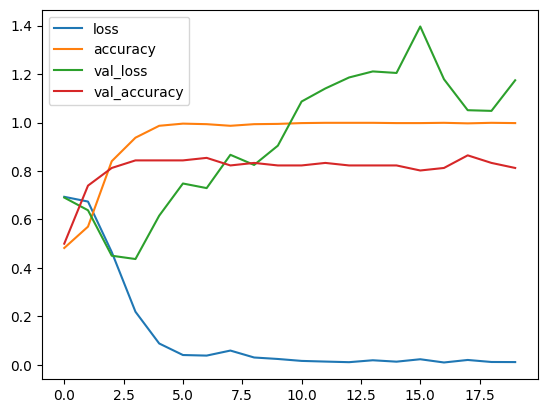

In [45]:
pd.DataFrame(history_lstm.history).plot()

In [46]:
test_labels = df[-98:-2]['Liked'].to_numpy()

In [47]:
lstm_y_preds = tf.round(lstm_model.predict(test_data))

3/3 [==============================] - 1s 6ms/step


In [48]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [49]:
calculate_results(test_labels, tf.squeeze(lstm_y_preds))

{'accuracy': 86.45833333333334,
 'precision': 0.864741641337386,
 'recall': 0.8645833333333334,
 'f1': 0.8645686380900705}

## Prediction on Reviews from the wild

In [50]:
classes = ['Negative Review', 'Positive Review']
def make_prediction(review):
  input_tensor = text_vectorizer([review])
  lstm_y_probs = lstm_model.predict(input_tensor)
  print(f'Input Sentence : \n{review}')
  print(f'Bi-LSTM Model Prediction : {classes[int(tf.squeeze(tf.round(lstm_y_probs)))]}')

In [51]:
make_prediction(['The Food was good'])

1/1 [==============================] - 2s 2s/step
Input Sentence : 
['The Food was good']
Bi-LSTM Model Prediction : Positive Review


In [52]:
make_prediction('The Food was not good, the curd was very salty and also the service was very late')

1/1 [==============================] - 0s 22ms/step
Input Sentence : 
The Food was not good, the curd was very salty and also the service was very late
Bi-LSTM Model Prediction : Positive Review


In [53]:
make_prediction('The Food was very disgusting')

1/1 [==============================] - 0s 44ms/step
Input Sentence : 
The Food was very disgusting
Bi-LSTM Model Prediction : Negative Review


In [54]:
make_prediction("The Food was alright but could've been better")

1/1 [==============================] - 0s 29ms/step
Input Sentence : 
The Food was alright but could've been better
Bi-LSTM Model Prediction : Negative Review


In [55]:
make_prediction('Service was very late, food was cold and not enjoyable')

1/1 [==============================] - 0s 39ms/step
Input Sentence : 
Service was very late, food was cold and not enjoyable
Bi-LSTM Model Prediction : Negative Review


## Saving our best model

In [56]:
lstm_model.save('Bi_LSTM_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [57]:
weights = text_vectorizer.get_weights()
np.save("text_vectorization_weights.npy", weights)